# Unbalanced datasets

In [1]:
data_folder = "../class-repo/cic1205/data/"
pickle_files = [
    "A602.pickle",
    "A621.pickle",
    "A627.pickle",
    "A636.pickle",
    "A652.pickle",
]

In [2]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import imblearn

# Preparing the pickle data

The y data comes as a continuous number, to make it a classification problem we need to convert it to a binary class matrix. We will categorize as follows in the function `transform_array`.

To provide a `value_counts()` of an array withou transforming it into a pandas DataFrame, I created the `count_values_list` function. This way we can check the distribution of the data and how unbalanced it is.

In [3]:
def transform_array(arr: np.ndarray) -> list:
    elems_list = [[1] if elem[0] != 0 else [0] for elem in arr]
    elems_array = np.array(elems_list)
    return elems_array


def count_values_list(lst: list) -> dict:
    if isinstance(lst, np.ndarray):
        try:
            lst = [1 if elem[0] != 0 else 0 for elem in lst]
        except IndexError:
            lst = [1 if elem != 0 else 0 for elem in lst]
    elif isinstance(lst, np.array):
        lst = lst.tolist()
    elif isinstance(lst, pd.Series):
        lst = lst.tolist()

    elems = set(lst)
    dict_counter = {elem: lst.count(elem) for elem in elems}

    return dict_counter

# Methodology

For every dataset the steps will be the same:
- Preprocess the data
    concatenate the dataframes to balance it afterwards
- Resample data
    - Random undersampling
        - Training and testing the model
    - Random oversampling
        - Training and testing the model



- Mixing both methods (Half sampling)
    - This one is a method where I try to not oversampling nor even undersampling, while doing both. I increase the minority to the half of the majority and then I undersample the majority to the same size as the minority.
        - Training and testing the model

I also was plannig to implement some `imblearn` algorithms, but I didn't have time to do it.

# A602


In [4]:
a602 = f"{data_folder}{pickle_files[0]}"
file = open(a602, "rb")
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10178, 24) (2565, 24) (765, 24)


In [6]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 9286, 1: 892}
y_val:   {0: 2265, 1: 300}
y_test:  {0: 673, 1: 92}


## Pre processing


In [7]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

In [8]:
zeroes = train_data[train_data[:, -1] == 0]
ones = train_data[train_data[:, -1] == 1]

## Resample


### Under Sampling


In [9]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=ones.shape[0], random_state=57
)

undersampled_train_data = np.concatenate(
    (undersampled_train_zeroes, ones), axis=0)

In [10]:
print(
    f"undersampled_train_data: {count_values_list(undersampled_train_data[:, -1])}")

undersampled_train_data: {0: 892, 1: 892}


In [11]:
X_train_undersampled = undersampled_train_data[:, :-1]
y_train_undersampled = undersampled_train_data[:, -1]

#### Training and Testing model


In [12]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_undersampled.shape}, {y_train_undersampled.shape}")
GB.fit(X_train_undersampled, y_train_undersampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (1784, 24), (1784,)

Validation
Shapes: (2565, 24), (2565,)
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2265
           1       0.31      0.85      0.45       300

    accuracy                           0.76      2565
   macro avg       0.64      0.80      0.65      2565
weighted avg       0.90      0.76      0.80      2565

[[1686  579]
 [  44  256]]

Test
Shapes: (765, 24), (765,)
              precision    recall  f1-score   support

           0       0.96      0.63      0.76       673
           1       0.23      0.82      0.36        92

    accuracy                           0.65       765
   macro avg       0.60      0.72      0.56       765
weighted avg       0.87      0.65      0.71       765

[[421 252]
 [ 17  75]]


### Over Sampling


In [13]:
oversampled_train_ones = resample(
    ones, replace=True, n_samples=len(zeroes), random_state=57
)

oversampled_train_data = np.concatenate(
    (zeroes, oversampled_train_ones), axis=0)

In [14]:
print(
    f"Oversampled_train_data: {count_values_list(oversampled_train_data[:, -1])}")

Oversampled_train_data: {0: 9286, 1: 9286}


In [15]:
X_train_oversampled = oversampled_train_data[:, :-1]
y_train_oversampled = oversampled_train_data[:, -1]

#### Training and Testing model


In [16]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_oversampled.shape}, {y_train_oversampled.shape}")
GB.fit(X_train_oversampled, y_train_oversampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (18572, 24), (18572,)



Validation
Shapes: (2565, 24), (2565,)
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      2265
           1       0.34      0.83      0.48       300

    accuracy                           0.79      2565
   macro avg       0.65      0.81      0.67      2565
weighted avg       0.90      0.79      0.82      2565

[[1777  488]
 [  52  248]]

Test
Shapes: (765, 24), (765,)
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       673
           1       0.33      0.77      0.47        92

    accuracy                           0.79       765
   macro avg       0.65      0.78      0.67       765
weighted avg       0.89      0.79      0.82       765

[[532 141]
 [ 21  71]]


## Mixing Both

In this mixing both section I want to try to mix both techniques to see if I can get a better result.

I will get all the rows from the train dataset and reduce the majority class to the half of the total and increase the minority class to the same number of the majority class.

Let's suppose we have n rows in total, after the process we will have n/2 rows of the majority class and n/2 rows of the minority class.

Then I will train the model with the new dataset and test it with the test dataset.

**Half Sampling**


In [17]:
n_rows = train_data.shape[0]

n_sample_size = n_rows // 2
print(f"n_sample_size: {n_sample_size}")

n_sample_size: 5089


In [18]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=n_sample_size, random_state=57
)
oversampled_train_ones = resample(
    ones, replace=True, n_samples=n_sample_size, random_state=57
)

halfsampled_train_data = np.concatenate(
    (undersampled_train_zeroes, oversampled_train_ones), axis=0
)

In [19]:
print(
    f"Halfsampled_train_data: {count_values_list(halfsampled_train_data[:, -1])}")

Halfsampled_train_data: {0: 5089, 1: 5089}


In [20]:
X_train_halfsampled = halfsampled_train_data[:, :-1]
y_train_halfsampled = halfsampled_train_data[:, -1]

#### Training and Testing model


In [21]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_halfsampled.shape}, {y_train_halfsampled.shape}")
GB.fit(X_train_halfsampled, y_train_halfsampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (10178, 24), (10178,)



Validation
Shapes: (2565, 24), (2565,)
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2265
           1       0.36      0.81      0.50       300

    accuracy                           0.81      2565
   macro avg       0.66      0.81      0.69      2565
weighted avg       0.90      0.81      0.84      2565

[[1827  438]
 [  56  244]]

Test
Shapes: (765, 24), (765,)
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       673
           1       0.28      0.71      0.40        92

    accuracy                           0.75       765
   macro avg       0.62      0.73      0.62       765
weighted avg       0.87      0.75      0.79       765

[[509 164]
 [ 27  65]]


## Changing the threshold


In [22]:
# Building a basic model fot the baseline

GB = GradientBoostingClassifier(random_state=57)
GB = GB.fit(X_train, y_train.ravel())

y_pred = GB.predict(X_val)

precision_original = round(precision_score(y_val, y_pred), 4)
recall_original = round(recall_score(y_val, y_pred), 4)
F1_score_original = round(f1_score(y_val, y_pred), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

In [23]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (GB.predict_proba(X_val)[:, 1] >= i).astype(
        int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round(
        (f1_score(y_val, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold,
                             recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

df_adj_threshold = adj_threshold.transpose().iloc[1:, :]
df_adj_threshold.columns = adj_threshold.iloc[:, 0]

In [24]:
df_adj_threshold

Metrics         Precision  Recall F1_score
Original           0.5668  0.6933   0.6237
Threshold: 0.05    0.2502  0.9233   0.3937
Threshold: 0.1     0.3687  0.8333   0.5112
Threshold: 0.15    0.4164  0.8133   0.5508
Threshold: 0.2       0.45    0.78   0.5707
Threshold: 0.25    0.4895  0.7733   0.5995
Threshold: 0.3     0.5147  0.7567   0.6127
Threshold: 0.35    0.5259  0.7433    0.616
Threshold: 0.4     0.5356  0.7267   0.6167
Threshold: 0.45    0.5556  0.7167   0.6259
Threshold: 0.5     0.5668  0.6933   0.6237
Threshold: 0.55    0.5903  0.6867   0.6348
Threshold: 0.6     0.5988  0.6667   0.6309
Threshold: 0.65    0.6287  0.6433   0.6359
Threshold: 0.7     0.6787  0.6267   0.6516
Threshold: 0.75    0.6935  0.5733   0.6277

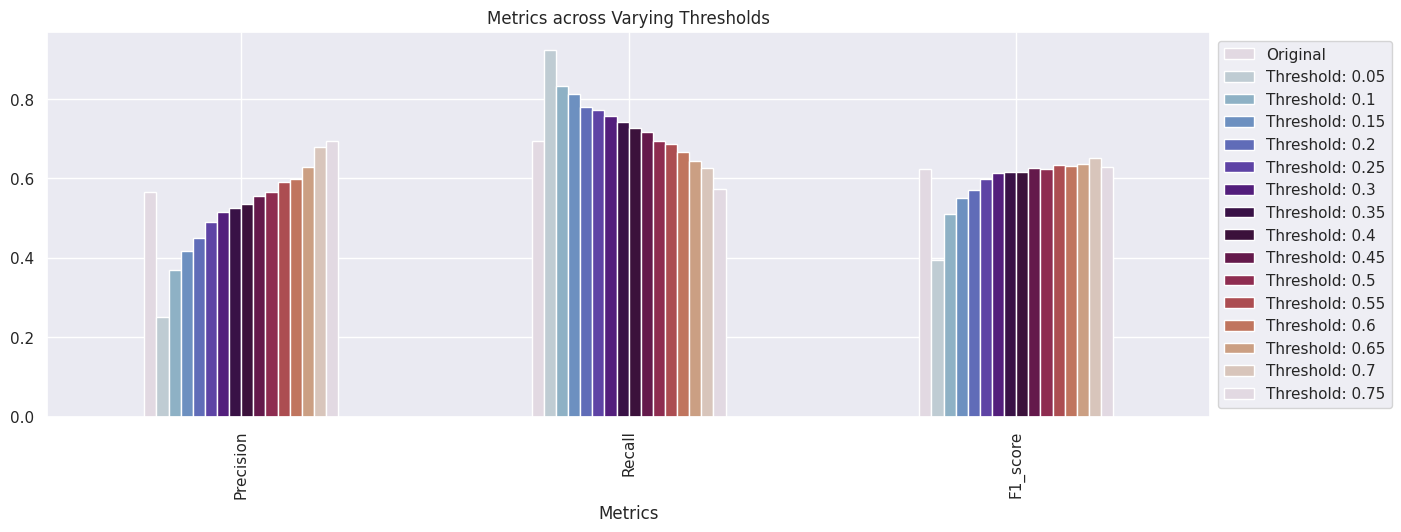

In [25]:
sns.set()
adj_threshold.plot(x='Metrics',
                   kind='bar',
                   stacked=False,
                   title='Metrics across Varying Thresholds',
                   figsize=(15, 5),
                   cmap='twilight').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Training and Testing the model with the optimal threshold


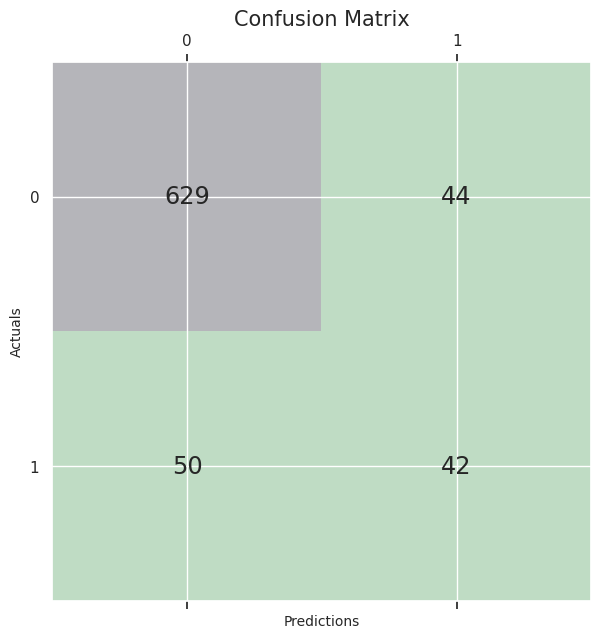

In [26]:
y_pred_new_threshold = (GB.predict_proba(X_test)[:, 1] >= 0.7).astype(int)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va="center", ha="center", size="x-large")

plt.xlabel("Predictions", fontsize=10)
plt.ylabel("Actuals", fontsize=10)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [27]:
precision_changedthreshold = round(
    precision_score(y_test, y_pred_new_threshold), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred_new_threshold), 4)
F1_changedthreshold = round(f1_score(y_test, y_pred_new_threshold), 4)
metrics_changedthreshold = [precision_changedthreshold,
                            recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(
    list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original Dataset', 'Threshold Changed Dataset']
changedthreshold

Original Dataset  Threshold Changed Dataset
Precision            0.5668                     0.4884
Recall               0.6933                     0.4565
F1_score             0.6237                     0.4719

## imblearn (to do)


### Under Sampling - SMOTE


In [28]:
from imblearn.over_sampling import SMOTE

#### Training and Testing model


#### Under Sampling - ADASYN


In [29]:
from imblearn.over_sampling import ADASYN

#### Training and Testing model


### Over Sampling


In [30]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

#### Training and Testing model


#### Training and Testing model


# A621


In [31]:
a621 = f"{data_folder}{pickle_files[1]}"
file = open(a621, "rb")
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (9549, 24) (2428, 24) (10080, 24)


In [32]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 8786, 1: 763}
y_val:   {0: 2201, 1: 227}
y_test:  {0: 9147, 1: 933}


## Pre processing


In [33]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

In [34]:
zeroes = train_data[train_data[:, -1] == 0]
ones = train_data[train_data[:, -1] == 1]

## Resample


### Under Sampling


In [35]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=ones.shape[0], random_state=57
)

undersampled_train_data = np.concatenate(
    (undersampled_train_zeroes, ones), axis=0)

In [36]:
print(
    f"undersampled_train_data: {count_values_list(undersampled_train_data[:, -1])}")

undersampled_train_data: {0: 763, 1: 763}


In [37]:
X_train_undersampled = undersampled_train_data[:, :-1]
y_train_undersampled = undersampled_train_data[:, -1]

#### Training and Testing model


In [38]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_undersampled.shape}, {y_train_undersampled.shape}")
GB.fit(X_train_undersampled, y_train_undersampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (1526, 24), (1526,)

Validation
Shapes: (2428, 24), (2428,)
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2201
           1       0.29      0.86      0.44       227

    accuracy                           0.79      2428
   macro avg       0.64      0.82      0.66      2428
weighted avg       0.92      0.79      0.83      2428

[[1731  470]
 [  31  196]]

Test
Shapes: (10080, 24), (10080,)
              precision    recall  f1-score   support

           0       0.98      0.44      0.61      9147
           1       0.14      0.93      0.25       933

    accuracy                           0.49     10080
   macro avg       0.56      0.68      0.43     10080
weighted avg       0.91      0.49      0.58     10080

[[4031 5116]
 [  69  864]]


### Over Sampling


In [39]:
oversampled_train_ones = resample(
    ones, replace=True, n_samples=len(zeroes), random_state=57
)

oversampled_train_data = np.concatenate(
    (zeroes, oversampled_train_ones), axis=0)

In [40]:
print(
    f"Oversampled_train_data: {count_values_list(oversampled_train_data[:, -1])}")

Oversampled_train_data: {0: 8786, 1: 8786}


In [41]:
X_train_oversampled = oversampled_train_data[:, :-1]
y_train_oversampled = oversampled_train_data[:, -1]

#### Training and Testing model


In [42]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_oversampled.shape}, {y_train_oversampled.shape}")
GB.fit(X_train_oversampled, y_train_oversampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (17572, 24), (17572,)



Validation
Shapes: (2428, 24), (2428,)
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2201
           1       0.33      0.66      0.44       227

    accuracy                           0.85      2428
   macro avg       0.65      0.76      0.68      2428
weighted avg       0.90      0.85      0.87      2428

[[1902  299]
 [  77  150]]

Test
Shapes: (10080, 24), (10080,)
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      9147
           1       0.17      0.87      0.29       933

    accuracy                           0.60     10080
   macro avg       0.57      0.72      0.50     10080
weighted avg       0.90      0.60      0.68     10080

[[5208 3939]
 [ 122  811]]


## Mixing Both

In this mixing both section I want to try to mix both techniques to see if I can get a better result.

I will get all the rows from the train dataset and reduce the majority class to the half of the total and increase the minority class to the same number of the majority class.

Let's suppose we have n rows in total, after the process we will have n/2 rows of the majority class and n/2 rows of the minority class.

Then I will train the model with the new dataset and test it with the test dataset.

**Half Sampling**


In [43]:
n_rows = train_data.shape[0]

n_sample_size = n_rows // 2
print(f"n_sample_size: {n_sample_size}")

n_sample_size: 4774


In [44]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=n_sample_size, random_state=57
)
oversampled_train_ones = resample(
    ones, replace=True, n_samples=n_sample_size, random_state=57
)

halfsampled_train_data = np.concatenate(
    (undersampled_train_zeroes, oversampled_train_ones), axis=0
)

In [45]:
print(
    f"Halfsampled_train_data: {count_values_list(halfsampled_train_data[:, -1])}")

Halfsampled_train_data: {0: 4774, 1: 4774}


In [46]:
X_train_halfsampled = halfsampled_train_data[:, :-1]
y_train_halfsampled = halfsampled_train_data[:, -1]

#### Training and Testing model


In [47]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_halfsampled.shape}, {y_train_halfsampled.shape}")
GB.fit(X_train_halfsampled, y_train_halfsampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (9548, 24), (9548,)



Validation
Shapes: (2428, 24), (2428,)
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2201
           1       0.35      0.79      0.49       227

    accuracy                           0.85      2428
   macro avg       0.66      0.82      0.70      2428
weighted avg       0.92      0.85      0.87      2428

[[1875  326]
 [  48  179]]

Test
Shapes: (10080, 24), (10080,)
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      9147
           1       0.17      0.87      0.29       933

    accuracy                           0.60     10080
   macro avg       0.57      0.72      0.50     10080
weighted avg       0.90      0.60      0.68     10080

[[5190 3957]
 [ 119  814]]


## Changing the threshold


In [48]:
X_val

array([[0.44705882, 0.61410788, 0.52702703, ..., 0.0669873 , 0.25      ,
        0.        ],
       [0.49411765, 0.58921162, 0.45945946, ..., 0.01703709, 0.37059048,
        0.        ],
       [0.55686275, 0.5560166 , 0.41891892, ..., 0.        , 0.5       ,
        0.        ],
       ...,
       [0.93333333, 0.01244813, 0.21621622, ..., 0.0669873 , 0.75      ,
        0.        ],
       [0.89803922, 0.00414938, 0.2027027 , ..., 0.14644661, 0.85355339,
        0.        ],
       [0.87058824, 0.        , 0.22972973, ..., 0.25      , 0.9330127 ,
        0.        ]])

In [49]:
# Building a basic model fot the baseline

GB = GradientBoostingClassifier(random_state=57)
GB = GB.fit(X_train, y_train.ravel())

y_pred = GB.predict(X_val)

precision_original = round(precision_score(y_val, y_pred), 4)
recall_original = round(recall_score(y_val, y_pred), 4)
F1_score_original = round(f1_score(y_val, y_pred), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

In [50]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (GB.predict_proba(X_val)[:, 1] >= i).astype(
        int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round(
        (f1_score(y_val, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold,
                             recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

df_adj_threshold = adj_threshold.transpose().iloc[1:, :]
df_adj_threshold.columns = adj_threshold.iloc[:, 0]

In [51]:
df_adj_threshold

Metrics         Precision  Recall F1_score
Original            0.629  0.5154   0.5666
Threshold: 0.05     0.201  0.8987   0.3285
Threshold: 0.1     0.3787  0.7974   0.5135
Threshold: 0.15     0.456  0.7533   0.5681
Threshold: 0.2     0.4969  0.7048   0.5829
Threshold: 0.25    0.5429  0.6696   0.5996
Threshold: 0.3     0.5703  0.6432   0.6046
Threshold: 0.35    0.5733  0.5859   0.5795
Threshold: 0.4     0.5935  0.5595    0.576
Threshold: 0.45    0.6188  0.5507   0.5828
Threshold: 0.5      0.629  0.5154   0.5666
Threshold: 0.55     0.659  0.5022     0.57
Threshold: 0.6     0.6879  0.4758   0.5625
Threshold: 0.65    0.6993  0.4405   0.5405
Threshold: 0.7     0.7391  0.3744   0.4971
Threshold: 0.75      0.74   0.326   0.4526

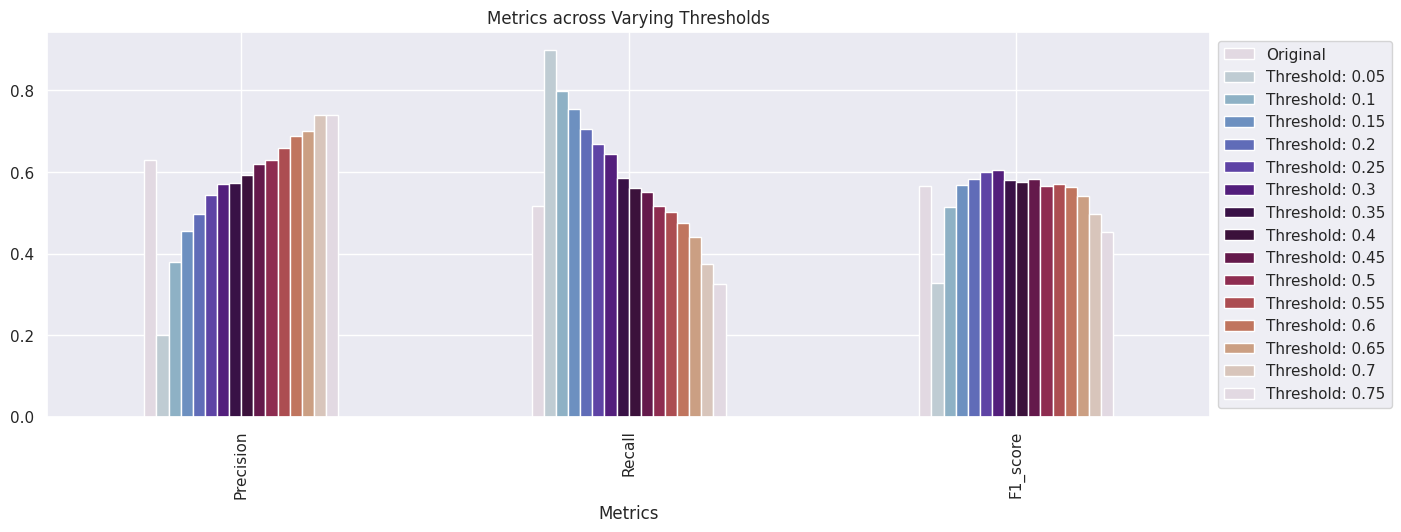

In [52]:
sns.set()
adj_threshold.plot(x='Metrics',
                   kind='bar',
                   stacked=False,
                   title='Metrics across Varying Thresholds',
                   figsize=(15, 5),
                   cmap='twilight').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Training and Testing the model with the optimal threshold


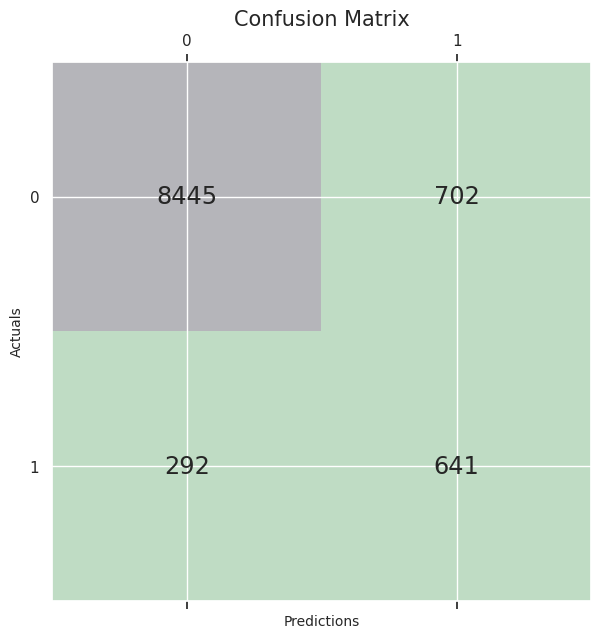

In [53]:
y_pred_new_threshold = (GB.predict_proba(X_test)[:, 1] >= 0.25).astype(int)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va="center", ha="center", size="x-large")

plt.xlabel("Predictions", fontsize=10)
plt.ylabel("Actuals", fontsize=10)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [54]:
precision_changedthreshold = round(
    precision_score(y_test, y_pred_new_threshold), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred_new_threshold), 4)
F1_changedthreshold = round(f1_score(y_test, y_pred_new_threshold), 4)
metrics_changedthreshold = [precision_changedthreshold,
                            recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(
    list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original Dataset', 'Threshold Changed Dataset']
changedthreshold

Original Dataset  Threshold Changed Dataset
Precision            0.6290                     0.4773
Recall               0.5154                     0.6870
F1_score             0.5666                     0.5633

# A627


In [55]:
a627 = f"{data_folder}{pickle_files[2]}"
file = open(a627, "rb")
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (9682, 24) (2235, 24) (10202, 24)


In [56]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 8910, 1: 772}
y_val:   {0: 1983, 1: 252}
y_test:  {0: 9200, 1: 1002}


## Pre processing


In [57]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

In [58]:
zeroes = train_data[train_data[:, -1] == 0]
ones = train_data[train_data[:, -1] == 1]

## Resample


### Under Sampling


In [59]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=ones.shape[0], random_state=57
)

undersampled_train_data = np.concatenate(
    (undersampled_train_zeroes, ones), axis=0)

In [60]:
print(
    f"undersampled_train_data: {count_values_list(undersampled_train_data[:, -1])}")

undersampled_train_data: {0: 772, 1: 772}


In [61]:
X_train_undersampled = undersampled_train_data[:, :-1]
y_train_undersampled = undersampled_train_data[:, -1]

#### Training and Testing model


In [62]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_undersampled.shape}, {y_train_undersampled.shape}")
GB.fit(X_train_undersampled, y_train_undersampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (1544, 24), (1544,)



Validation
Shapes: (2235, 24), (2235,)
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1983
           1       0.29      0.77      0.42       252

    accuracy                           0.76      2235
   macro avg       0.63      0.77      0.64      2235
weighted avg       0.89      0.76      0.80      2235

[[1510  473]
 [  57  195]]

Test
Shapes: (10202, 24), (10202,)
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      9200
           1       0.37      0.75      0.50      1002

    accuracy                           0.85     10202
   macro avg       0.67      0.81      0.71     10202
weighted avg       0.91      0.85      0.87     10202

[[7936 1264]
 [ 252  750]]


### Over Sampling


In [63]:
oversampled_train_ones = resample(
    ones, replace=True, n_samples=len(zeroes), random_state=57
)

oversampled_train_data = np.concatenate(
    (zeroes, oversampled_train_ones), axis=0)

In [64]:
print(
    f"Oversampled_train_data: {count_values_list(oversampled_train_data[:, -1])}")

Oversampled_train_data: {0: 8910, 1: 8910}


In [65]:
X_train_oversampled = oversampled_train_data[:, :-1]
y_train_oversampled = oversampled_train_data[:, -1]

#### Training and Testing model


In [66]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_oversampled.shape}, {y_train_oversampled.shape}")
GB.fit(X_train_oversampled, y_train_oversampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (17820, 24), (17820,)



Validation
Shapes: (2235, 24), (2235,)
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1983
           1       0.36      0.79      0.49       252

    accuracy                           0.82      2235
   macro avg       0.66      0.81      0.69      2235
weighted avg       0.90      0.82      0.84      2235

[[1625  358]
 [  52  200]]

Test
Shapes: (10202, 24), (10202,)
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      9200
           1       0.41      0.75      0.53      1002

    accuracy                           0.87     10202
   macro avg       0.69      0.82      0.73     10202
weighted avg       0.91      0.87      0.89     10202

[[8117 1083]
 [ 251  751]]


## Mixing Both

In this mixing both section I want to try to mix both techniques to see if I can get a better result.

I will get all the rows from the train dataset and reduce the majority class to the half of the total and increase the minority class to the same number of the majority class.

Let's suppose we have n rows in total, after the process we will have n/2 rows of the majority class and n/2 rows of the minority class.

Then I will train the model with the new dataset and test it with the test dataset.

**Half Sampling**


In [67]:
n_rows = train_data.shape[0]

n_sample_size = n_rows // 2
print(f"n_sample_size: {n_sample_size}")

n_sample_size: 4841


In [68]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=n_sample_size, random_state=57
)
oversampled_train_ones = resample(
    ones, replace=True, n_samples=n_sample_size, random_state=57
)

halfsampled_train_data = np.concatenate(
    (undersampled_train_zeroes, oversampled_train_ones), axis=0
)

In [69]:
print(
    f"Halfsampled_train_data: {count_values_list(halfsampled_train_data[:, -1])}")

Halfsampled_train_data: {0: 4841, 1: 4841}


In [70]:
X_train_halfsampled = halfsampled_train_data[:, :-1]
y_train_halfsampled = halfsampled_train_data[:, -1]

#### Training and Testing model


In [71]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_halfsampled.shape}, {y_train_halfsampled.shape}")
GB.fit(X_train_halfsampled, y_train_halfsampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (9682, 24), (9682,)



Validation
Shapes: (2235, 24), (2235,)
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1983
           1       0.39      0.76      0.51       252

    accuracy                           0.84      2235
   macro avg       0.68      0.80      0.71      2235
weighted avg       0.90      0.84      0.86      2235

[[1679  304]
 [  61  191]]

Test
Shapes: (10202, 24), (10202,)
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      9200
           1       0.41      0.75      0.53      1002

    accuracy                           0.87     10202
   macro avg       0.69      0.82      0.73     10202
weighted avg       0.92      0.87      0.89     10202

[[8128 1072]
 [ 252  750]]


## Changing the threshold


In [73]:
# Building a basic model fot the baseline

GB = GradientBoostingClassifier(random_state=57)
GB = GB.fit(X_train, y_train.ravel())

y_pred = GB.predict(X_val)

precision_original = round(precision_score(y_val, y_pred), 4)
recall_original = round(recall_score(y_val, y_pred), 4)
F1_score_original = round(f1_score(y_val, y_pred), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

In [74]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (GB.predict_proba(X_val)[:, 1] >= i).astype(
        int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round(
        (f1_score(y_val, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold,
                             recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

df_adj_threshold = adj_threshold.transpose().iloc[1:, :]
df_adj_threshold.columns = adj_threshold.iloc[:, 0]

In [75]:
df_adj_threshold

Metrics         Precision  Recall F1_score
Original           0.4373  0.6508   0.5231
Threshold: 0.05    0.1887  0.9167    0.313
Threshold: 0.1     0.2302  0.8651   0.3636
Threshold: 0.15    0.2712  0.8373   0.4097
Threshold: 0.2     0.2967  0.7817   0.4301
Threshold: 0.25     0.331  0.7579   0.4608
Threshold: 0.3     0.3531  0.7341   0.4768
Threshold: 0.35    0.3805  0.7143   0.4966
Threshold: 0.4     0.4051  0.6944   0.5117
Threshold: 0.45    0.4268  0.6825   0.5252
Threshold: 0.5     0.4373  0.6508   0.5231
Threshold: 0.55    0.4711  0.6151   0.5336
Threshold: 0.6     0.4833  0.5754   0.5254
Threshold: 0.65    0.5019  0.5198   0.5107
Threshold: 0.7     0.5212  0.4881   0.5041
Threshold: 0.75    0.5361  0.4127   0.4664

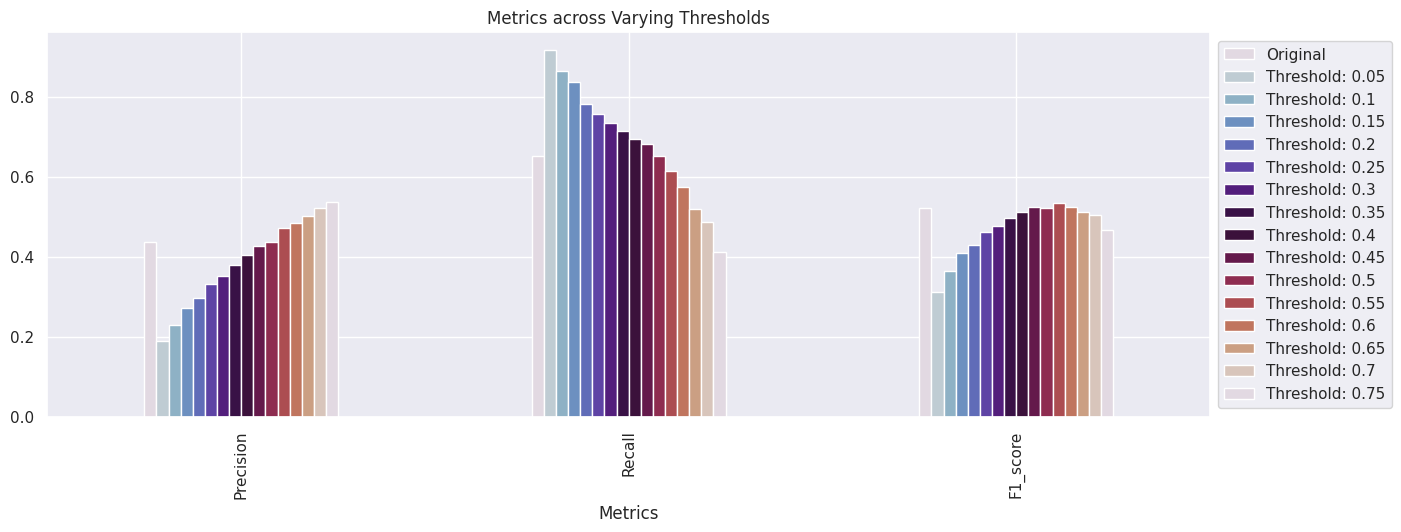

In [76]:
sns.set()
adj_threshold.plot(x='Metrics',
                   kind='bar',
                   stacked=False,
                   title='Metrics across Varying Thresholds',
                   figsize=(15, 5),
                   cmap='twilight').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Training and Testing the model with the optimal threshold


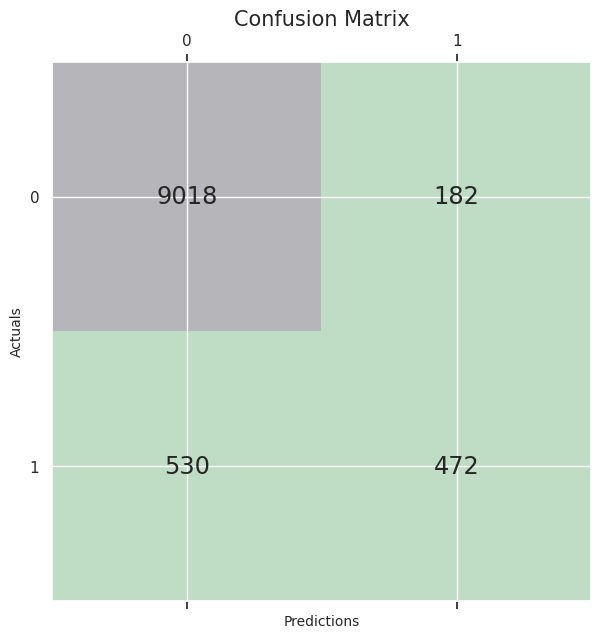

In [77]:
y_pred_new_threshold = (GB.predict_proba(X_test)[:, 1] >= 0.6).astype(int)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va="center", ha="center", size="x-large")

plt.xlabel("Predictions", fontsize=10)
plt.ylabel("Actuals", fontsize=10)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [78]:
precision_changedthreshold = round(
    precision_score(y_test, y_pred_new_threshold), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred_new_threshold), 4)
F1_changedthreshold = round(f1_score(y_test, y_pred_new_threshold), 4)
metrics_changedthreshold = [precision_changedthreshold,
                            recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(
    list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original Dataset', 'Threshold Changed Dataset']
changedthreshold

Original Dataset  Threshold Changed Dataset
Precision            0.4373                     0.7217
Recall               0.6508                     0.4711
F1_score             0.5231                     0.5700

# A636


In [79]:
a636 = f"{data_folder}{pickle_files[3]}"
file = open(a636, "rb")
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10219, 24) (2414, 24) (10129, 24)


In [80]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 9236, 1: 983}
y_val:   {0: 2149, 1: 265}
y_test:  {0: 9017, 1: 1112}


## Pre processing


In [81]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

In [82]:
zeroes = train_data[train_data[:, -1] == 0]
ones = train_data[train_data[:, -1] == 1]

## Resample


### Under Sampling


In [83]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=ones.shape[0], random_state=57
)

undersampled_train_data = np.concatenate(
    (undersampled_train_zeroes, ones), axis=0)

In [84]:
print(
    f"undersampled_train_data: {count_values_list(undersampled_train_data[:, -1])}")

undersampled_train_data: {0: 983, 1: 983}


In [85]:
X_train_undersampled = undersampled_train_data[:, :-1]
y_train_undersampled = undersampled_train_data[:, -1]

#### Training and Testing model


In [86]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_undersampled.shape}, {y_train_undersampled.shape}")
GB.fit(X_train_undersampled, y_train_undersampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (1966, 24), (1966,)

Validation
Shapes: (2414, 24), (2414,)
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2149
           1       0.47      0.78      0.59       265

    accuracy                           0.88      2414
   macro avg       0.72      0.84      0.76      2414
weighted avg       0.92      0.88      0.89      2414

[[1916  233]
 [  58  207]]

Test
Shapes: (10129, 24), (10129,)
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      9017
           1       0.29      0.76      0.42      1112

    accuracy                           0.77     10129
   macro avg       0.63      0.77      0.64     10129
weighted avg       0.89      0.77      0.81     10129

[[7009 2008]
 [ 272  840]]


### Over Sampling


In [87]:
oversampled_train_ones = resample(
    ones, replace=True, n_samples=len(zeroes), random_state=57
)

oversampled_train_data = np.concatenate(
    (zeroes, oversampled_train_ones), axis=0)

In [88]:
print(
    f"Oversampled_train_data: {count_values_list(oversampled_train_data[:, -1])}")

Oversampled_train_data: {0: 9236, 1: 9236}


In [89]:
X_train_oversampled = oversampled_train_data[:, :-1]
y_train_oversampled = oversampled_train_data[:, -1]

#### Training and Testing model


In [90]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_oversampled.shape}, {y_train_oversampled.shape}")
GB.fit(X_train_oversampled, y_train_oversampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (18472, 24), (18472,)



Validation
Shapes: (2414, 24), (2414,)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2149
           1       0.59      0.74      0.66       265

    accuracy                           0.92      2414
   macro avg       0.78      0.84      0.80      2414
weighted avg       0.93      0.92      0.92      2414

[[2015  134]
 [  70  195]]

Test
Shapes: (10129, 24), (10129,)
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      9017
           1       0.36      0.74      0.49      1112

    accuracy                           0.83     10129
   macro avg       0.66      0.79      0.69     10129
weighted avg       0.90      0.83      0.85     10129

[[7585 1432]
 [ 292  820]]


## Mixing Both

In this mixing both section I want to try to mix both techniques to see if I can get a better result.

I will get all the rows from the train dataset and reduce the majority class to the half of the total and increase the minority class to the same number of the majority class.

Let's suppose we have n rows in total, after the process we will have n/2 rows of the majority class and n/2 rows of the minority class.

Then I will train the model with the new dataset and test it with the test dataset.

**Half Sampling**


In [91]:
n_rows = train_data.shape[0]

n_sample_size = n_rows // 2
print(f"n_sample_size: {n_sample_size}")

n_sample_size: 5109


In [92]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=n_sample_size, random_state=57
)
oversampled_train_ones = resample(
    ones, replace=True, n_samples=n_sample_size, random_state=57
)

halfsampled_train_data = np.concatenate(
    (undersampled_train_zeroes, oversampled_train_ones), axis=0
)

In [93]:
print(
    f"Halfsampled_train_data: {count_values_list(halfsampled_train_data[:, -1])}")

Halfsampled_train_data: {0: 5109, 1: 5109}


In [94]:
X_train_halfsampled = halfsampled_train_data[:, :-1]
y_train_halfsampled = halfsampled_train_data[:, -1]

#### Training and Testing model


In [95]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_halfsampled.shape}, {y_train_halfsampled.shape}")
GB.fit(X_train_halfsampled, y_train_halfsampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (10218, 24), (10218,)



Validation
Shapes: (2414, 24), (2414,)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2149
           1       0.59      0.75      0.66       265

    accuracy                           0.92      2414
   macro avg       0.78      0.85      0.81      2414
weighted avg       0.93      0.92      0.92      2414

[[2010  139]
 [  65  200]]

Test
Shapes: (10129, 24), (10129,)
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      9017
           1       0.35      0.75      0.47      1112

    accuracy                           0.82     10129
   macro avg       0.65      0.79      0.68     10129
weighted avg       0.90      0.82      0.84     10129

[[7442 1575]
 [ 279  833]]


## Changing the threshold


In [97]:
# Building a basic model fot the baseline

GB = GradientBoostingClassifier(random_state=57)
GB = GB.fit(X_train, y_train.ravel())

y_pred = GB.predict(X_val)

precision_original = round(precision_score(y_val, y_pred), 4)
recall_original = round(recall_score(y_val, y_pred), 4)
F1_score_original = round(f1_score(y_val, y_pred), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

In [98]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (GB.predict_proba(X_val)[:, 1] >= i).astype(
        int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round(
        (f1_score(y_val, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold,
                             recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

df_adj_threshold = adj_threshold.transpose().iloc[1:, :]
df_adj_threshold.columns = adj_threshold.iloc[:, 0]

In [99]:
df_adj_threshold

Metrics         Precision  Recall F1_score
Original           0.7333  0.5811   0.6484
Threshold: 0.05    0.3153  0.8377   0.4582
Threshold: 0.1       0.52  0.7849   0.6256
Threshold: 0.15    0.5702  0.7509   0.6482
Threshold: 0.2     0.6117  0.7132   0.6585
Threshold: 0.25    0.6401  0.6981   0.6679
Threshold: 0.3     0.6605  0.6755   0.6679
Threshold: 0.35    0.6875  0.6642   0.6756
Threshold: 0.4     0.7025  0.6415   0.6706
Threshold: 0.45    0.7285  0.6075   0.6626
Threshold: 0.5     0.7333  0.5811   0.6484
Threshold: 0.55    0.7423  0.5434   0.6275
Threshold: 0.6     0.7568  0.5283   0.6222
Threshold: 0.65       0.8  0.4981    0.614
Threshold: 0.7     0.7973  0.4453   0.5714
Threshold: 0.75     0.803     0.4    0.534

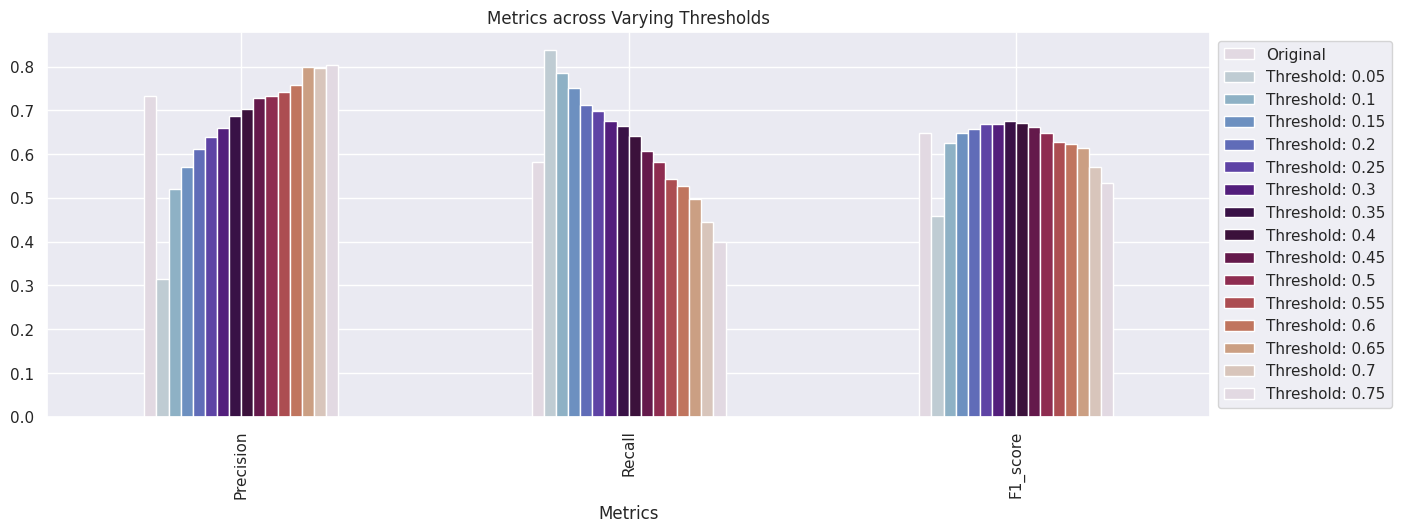

In [100]:
sns.set()
adj_threshold.plot(x='Metrics',
                   kind='bar',
                   stacked=False,
                   title='Metrics across Varying Thresholds',
                   figsize=(15, 5),
                   cmap='twilight').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Training and Testing the model with the optimal threshold


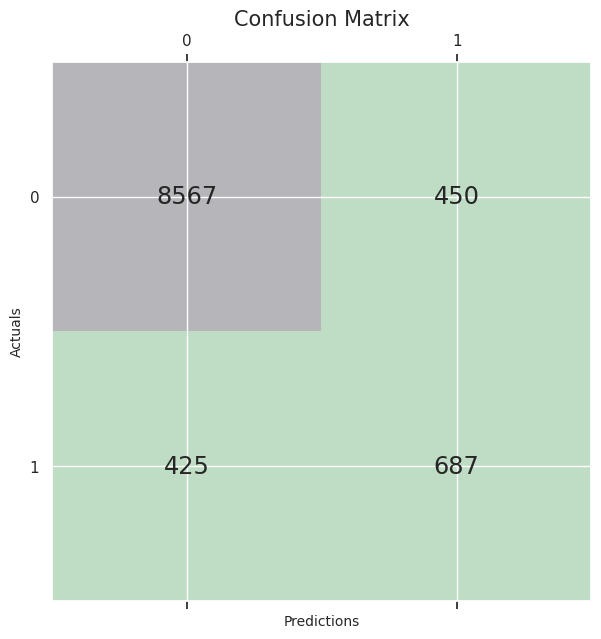

In [101]:
y_pred_new_threshold = (GB.predict_proba(X_test)[:, 1] >= 0.35).astype(int)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va="center", ha="center", size="x-large")

plt.xlabel("Predictions", fontsize=10)
plt.ylabel("Actuals", fontsize=10)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [102]:
precision_changedthreshold = round(
    precision_score(y_test, y_pred_new_threshold), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred_new_threshold), 4)
F1_changedthreshold = round(f1_score(y_test, y_pred_new_threshold), 4)
metrics_changedthreshold = [precision_changedthreshold,
                            recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(
    list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original Dataset', 'Threshold Changed Dataset']
changedthreshold

Original Dataset  Threshold Changed Dataset
Precision            0.7333                     0.6042
Recall               0.5811                     0.6178
F1_score             0.6484                     0.6109

# A652


In [103]:
a652 = f"{data_folder}{pickle_files[4]}"
file = open(a652, "rb")
(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(file)
print(f"Shapes: ", X_train.shape, X_val.shape, X_test.shape)

Shapes:  (10012, 24) (2506, 24) (9582, 24)


In [104]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 9258, 1: 754}
y_val:   {0: 2277, 1: 229}
y_test:  {0: 8769, 1: 813}


## Pre processing


In [105]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

In [106]:
zeroes = train_data[train_data[:, -1] == 0]
ones = train_data[train_data[:, -1] == 1]

## Resample


### Under Sampling


In [107]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=ones.shape[0], random_state=57
)

undersampled_train_data = np.concatenate(
    (undersampled_train_zeroes, ones), axis=0)

In [108]:
print(
    f"undersampled_train_data: {count_values_list(undersampled_train_data[:, -1])}")

undersampled_train_data: {0: 754, 1: 754}


In [109]:
X_train_undersampled = undersampled_train_data[:, :-1]
y_train_undersampled = undersampled_train_data[:, -1]

#### Training and Testing model


In [110]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_undersampled.shape}, {y_train_undersampled.shape}")
GB.fit(X_train_undersampled, y_train_undersampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (1508, 24), (1508,)

Validation
Shapes: (2506, 24), (2506,)
              precision    recall  f1-score   support

           0       0.97      0.86      0.92      2277
           1       0.36      0.76      0.49       229

    accuracy                           0.85      2506
   macro avg       0.67      0.81      0.70      2506
weighted avg       0.92      0.85      0.88      2506

[[1967  310]
 [  54  175]]

Test
Shapes: (9582, 24), (9582,)
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8769
           1       0.43      0.74      0.55       813

    accuracy                           0.90      9582
   macro avg       0.70      0.82      0.74      9582
weighted avg       0.93      0.90      0.91      9582

[[7984  785]
 [ 214  599]]


### Over Sampling


In [111]:
oversampled_train_ones = resample(
    ones, replace=True, n_samples=len(zeroes), random_state=57
)

oversampled_train_data = np.concatenate(
    (zeroes, oversampled_train_ones), axis=0)

In [112]:
print(
    f"Oversampled_train_data: {count_values_list(oversampled_train_data[:, -1])}")

Oversampled_train_data: {0: 9258, 1: 9258}


In [113]:
X_train_oversampled = oversampled_train_data[:, :-1]
y_train_oversampled = oversampled_train_data[:, -1]

#### Training and Testing model


In [114]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_oversampled.shape}, {y_train_oversampled.shape}")
GB.fit(X_train_oversampled, y_train_oversampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (18516, 24), (18516,)



Validation
Shapes: (2506, 24), (2506,)
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2277
           1       0.43      0.69      0.53       229

    accuracy                           0.89      2506
   macro avg       0.70      0.80      0.73      2506
weighted avg       0.92      0.89      0.90      2506

[[2063  214]
 [  70  159]]

Test
Shapes: (9582, 24), (9582,)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8769
           1       0.50      0.64      0.56       813

    accuracy                           0.92      9582
   macro avg       0.73      0.79      0.76      9582
weighted avg       0.93      0.92      0.92      9582

[[8247  522]
 [ 290  523]]


## Mixing Both

In this mixing both section I want to try to mix both techniques to see if I can get a better result.

I will get all the rows from the train dataset and reduce the majority class to the half of the total and increase the minority class to the same number of the majority class.

Let's suppose we have n rows in total, after the process we will have n/2 rows of the majority class and n/2 rows of the minority class.

Then I will train the model with the new dataset and test it with the test dataset.

**Half Sampling**


In [115]:
n_rows = train_data.shape[0]

n_sample_size = n_rows // 2
print(f"n_sample_size: {n_sample_size}")

n_sample_size: 5006


In [116]:
undersampled_train_zeroes = resample(
    zeroes, replace=False, n_samples=n_sample_size, random_state=57
)
oversampled_train_ones = resample(
    ones, replace=True, n_samples=n_sample_size, random_state=57
)

halfsampled_train_data = np.concatenate(
    (undersampled_train_zeroes, oversampled_train_ones), axis=0
)

In [117]:
print(
    f"Halfsampled_train_data: {count_values_list(halfsampled_train_data[:, -1])}")

Halfsampled_train_data: {0: 5006, 1: 5006}


In [118]:
X_train_halfsampled = halfsampled_train_data[:, :-1]
y_train_halfsampled = halfsampled_train_data[:, -1]

#### Training and Testing model


In [119]:
GB = GradientBoostingClassifier(random_state=57)

print(
    f"Train shapes: {X_train_halfsampled.shape}, {y_train_halfsampled.shape}")
GB.fit(X_train_halfsampled, y_train_halfsampled)

y_pred = GB.predict(X_val)
print("\nValidation")
print(f"Shapes: {X_val.shape}, {y_pred.shape}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

y_pred = GB.predict(X_test)
print("\nTest")
print(f"Shapes: {X_test.shape}, {y_pred.shape}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train shapes: (10012, 24), (10012,)



Validation
Shapes: (2506, 24), (2506,)
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2277
           1       0.44      0.66      0.53       229

    accuracy                           0.89      2506
   macro avg       0.70      0.79      0.73      2506
weighted avg       0.92      0.89      0.90      2506

[[2084  193]
 [  77  152]]

Test
Shapes: (9582, 24), (9582,)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8769
           1       0.49      0.68      0.57       813

    accuracy                           0.91      9582
   macro avg       0.73      0.81      0.76      9582
weighted avg       0.93      0.91      0.92      9582

[[8200  569]
 [ 263  550]]


## Changing the threshold


In [120]:
# Building a basic model fot the baseline

GB = GradientBoostingClassifier(random_state=57)
GB = GB.fit(X_train, y_train.ravel())

y_pred = GB.predict(X_val)

precision_original = round(precision_score(y_val, y_pred), 4)
recall_original = round(recall_score(y_val, y_pred), 4)
F1_score_original = round(f1_score(y_val, y_pred), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

In [121]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [j/20 for j in range(1, 16)]

for i in thresholds:
    y_pred_new_threshold = (GB.predict_proba(X_val)[:, 1] >= i).astype(
        int)  # calculating the threshold with respect to class 1

    precision_adj_threshold = round(precision_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(
        y_val, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold = round(
        (f1_score(y_val, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold,
                             recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i)
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

df_adj_threshold = adj_threshold.transpose().iloc[1:, :]
df_adj_threshold.columns = adj_threshold.iloc[:, 0]

In [122]:
df_adj_threshold

Metrics         Precision  Recall F1_score
Original            0.736  0.4017   0.5198
Threshold: 0.05    0.3196  0.8821   0.4692
Threshold: 0.1     0.4757  0.7686   0.5876
Threshold: 0.15    0.5754  0.7162   0.6381
Threshold: 0.2     0.6235  0.6725   0.6471
Threshold: 0.25    0.6532  0.6332    0.643
Threshold: 0.3     0.6667  0.5852   0.6233
Threshold: 0.35    0.6684  0.5633   0.6114
Threshold: 0.4     0.6879  0.5197    0.592
Threshold: 0.45      0.68  0.4454   0.5383
Threshold: 0.5      0.736  0.4017   0.5198
Threshold: 0.55    0.7182   0.345   0.4661
Threshold: 0.6     0.7381  0.2707   0.3962
Threshold: 0.65    0.8154  0.2314   0.3605
Threshold: 0.7       0.84  0.1834   0.3011
Threshold: 0.75    0.8718  0.1485   0.2537

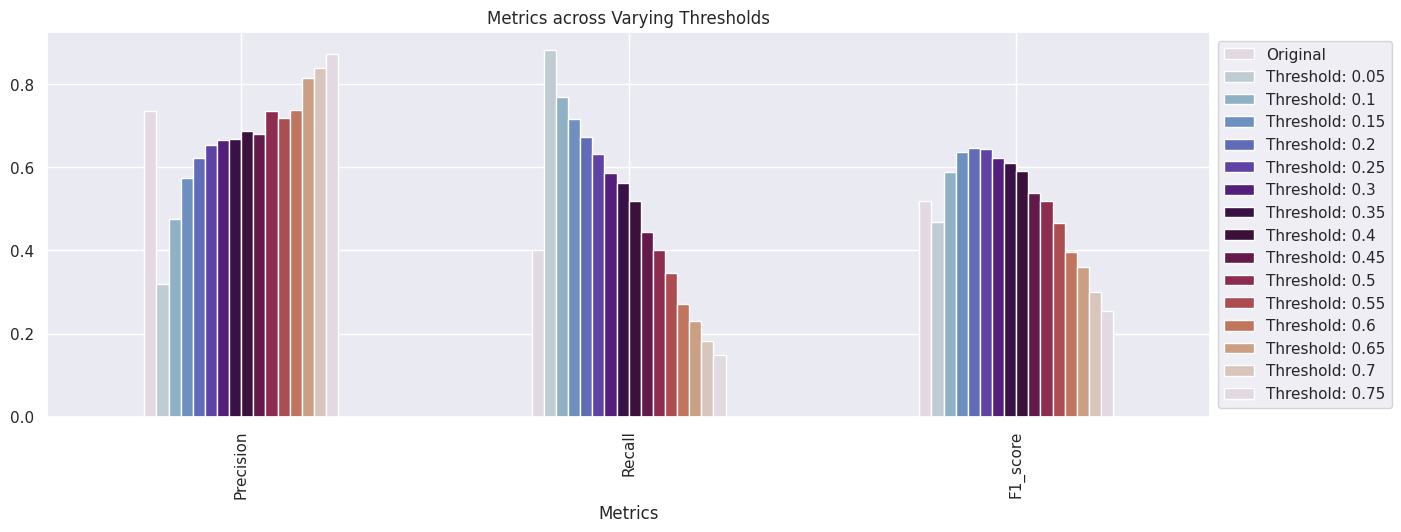

In [123]:
sns.set()
adj_threshold.plot(x='Metrics',
                   kind='bar',
                   stacked=False,
                   title='Metrics across Varying Thresholds',
                   figsize=(15, 5),
                   cmap='twilight').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### Training and Testing the model with the optimal threshold


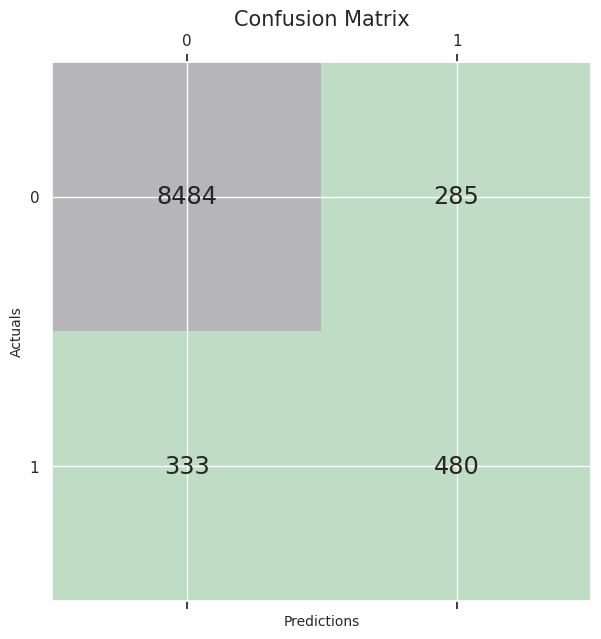

In [124]:
y_pred_new_threshold = (GB.predict_proba(X_test)[:, 1] >= 0.2).astype(int)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_new_threshold)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j],
                va="center", ha="center", size="x-large")

plt.xlabel("Predictions", fontsize=10)
plt.ylabel("Actuals", fontsize=10)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

In [125]:
precision_changedthreshold = round(
    precision_score(y_test, y_pred_new_threshold), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred_new_threshold), 4)
F1_changedthreshold = round(f1_score(y_test, y_pred_new_threshold), 4)
metrics_changedthreshold = [precision_changedthreshold,
                            recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(
    list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original Dataset', 'Threshold Changed Dataset']
changedthreshold

Original Dataset  Threshold Changed Dataset
Precision            0.7360                     0.6275
Recall               0.4017                     0.5904
F1_score             0.5198                     0.6084